In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import sys

sys.path.append("..")

import os
from PIL import Image
from collections.abc import Iterable
from os.path import dirname, join, abspath

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from joblib import Parallel, delayed
from matplotlib.ticker import FuncFormatter
from skimage.color import label2rgb
# load label
from skimage.measure import label, find_contours
from skimage import transform
import subprocess

from utils import *
from pred2raster import pred2raster
from sample_selection import get_components_stats
from src.io_operations import fix_relative_paths, load_args, read_tiff, read_yaml

from IPython.display import HTML, display

from millify import  millify

from matplotlib import rc

from statistics import mode

from tqdm import tqdm
from seaborn import color_palette
from glob import glob

from scipy.ndimage import distance_transform_edt, gaussian_filter
import gc

from concurrent.futures import ProcessPoolExecutor

# First of All, Create an Empty Image Template

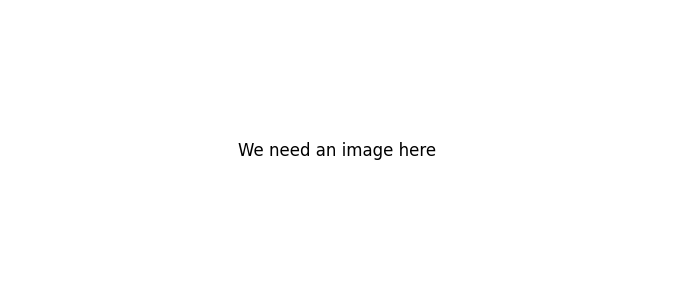

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=120)
# write on the middle that is missing a image here
ax.text(0.5, 0.5, "We need an image here", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.axis('off')
plt.show()

In [14]:
INPUT_FOLDER = "../amazon_input_data"
VERSAO = "13_amazon_data"
ITER_FOLDER = "iter_001"

In [15]:
args = load_args(join(ROOT_PATH, VERSAO, "args.yaml"))

In [16]:
ORTHOIMAGE = read_tiff(args.ortho_image)
ORTHOIMAGE = np.moveaxis(ORTHOIMAGE, 0, 2)

In [17]:
LABEL_GT_TRAIN = read_tiff(args.train_segmentation_path)

LABEL_GT_TEST = read_tiff(args.test_segmentation_path)

MASK = read_tiff(args.mask_path)

In [18]:
class_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "join_class*"))[0]
)

depth_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "depth*"))[0]
)
depth_pred = np.float32(depth_pred) / 255


prob_pred = read_tiff(
    glob(join(ROOT_PATH, VERSAO, ITER_FOLDER, "raster_prediction", "join_prob*"))[0]
)
prob_pred = np.float32(prob_pred) / 255

In [19]:
num_classes = pd.unique(pd.Series(class_pred.ravel())).shape[0]

In [20]:
COMP_TEST_GT = label(LABEL_GT_TEST)
COMP_TRAIN_GT = label(LABEL_GT_TRAIN)

In [21]:
DEFAULT_COLORS = color_palette("tab20", num_classes)
DEFAULT_COLORS.insert(0, (0,0,0))

In [22]:
# prob_gauss = gaussian_filter(prob_pred, sigma = 20)
# depth_gauss = gaussian_filter(depth_pred, sigma = 20)

with ProcessPoolExecutor() as executor:
    future_prob = executor.submit(gaussian_filter, prob_pred, 20)
    future_depth = executor.submit(gaussian_filter, depth_pred, 20)
    
    prob_gauss = future_prob.result()
    depth_gauss = future_depth.result()

In [23]:
prob_pred.max()

0.99607843

In [24]:
depth_pred.max()

0.8784314

## Comparação das Imagens com Diferentes Thresholds

In [25]:
high_prob_pred = np.where(prob_gauss > 0.7, class_pred, 0)
high_prob_depth_pred = np.where((prob_gauss > 0.7) & (depth_gauss > 0.2), class_pred, 0)

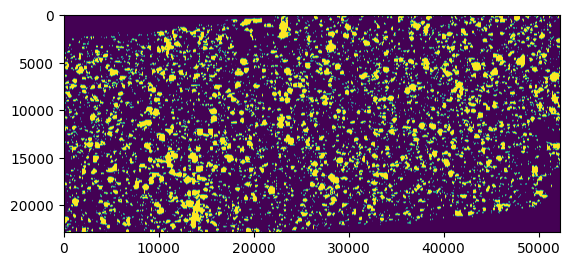

In [26]:
plt.imshow(np.where(prob_gauss>0.7,1,0))

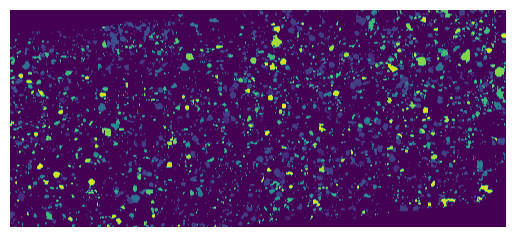

In [27]:
plt.figure(dpi=100)
plt.imshow(high_prob_pred)
plt.axis("off")
plt.show()

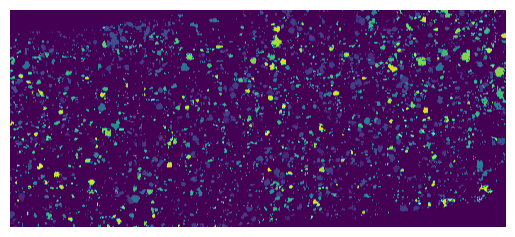

In [28]:
plt.figure(dpi=100)
plt.imshow(high_prob_depth_pred)
plt.axis("off")
plt.show()

## Ilustração dos Patches de Treinamento

In [29]:
quadrante_img = COMP_TRAIN_GT[7_000:14_500, 14_500:22_000].copy()

# set zero in all borders
width = 250
labels_in_borders = np.concatenate([
    np.unique(quadrante_img[:width,:]),
    np.unique(quadrante_img[-width:,:]),
    np.unique(quadrante_img[:,-width:]),
    np.unique(quadrante_img[:, :width])
])

quadrante_img = np.where(np.isin(quadrante_img,labels_in_borders), 0, quadrante_img)

quadrante_raw = ORTHOIMAGE[7_000:14_500, 14_500:22_000].copy()

In [30]:
all_coords = [ ]

for idx in np.unique(quadrante_img):
    if idx == 0:
        continue
    
    coords_quad = np.argwhere(quadrante_img == idx)
    
    random_idx = np.random.randint(0, coords_quad.shape[0], size = 3)

    coords_to_box = coords_quad[random_idx].copy()
    
    all_coords.append(coords_to_box.copy())


all_coords = np.concatenate(all_coords)

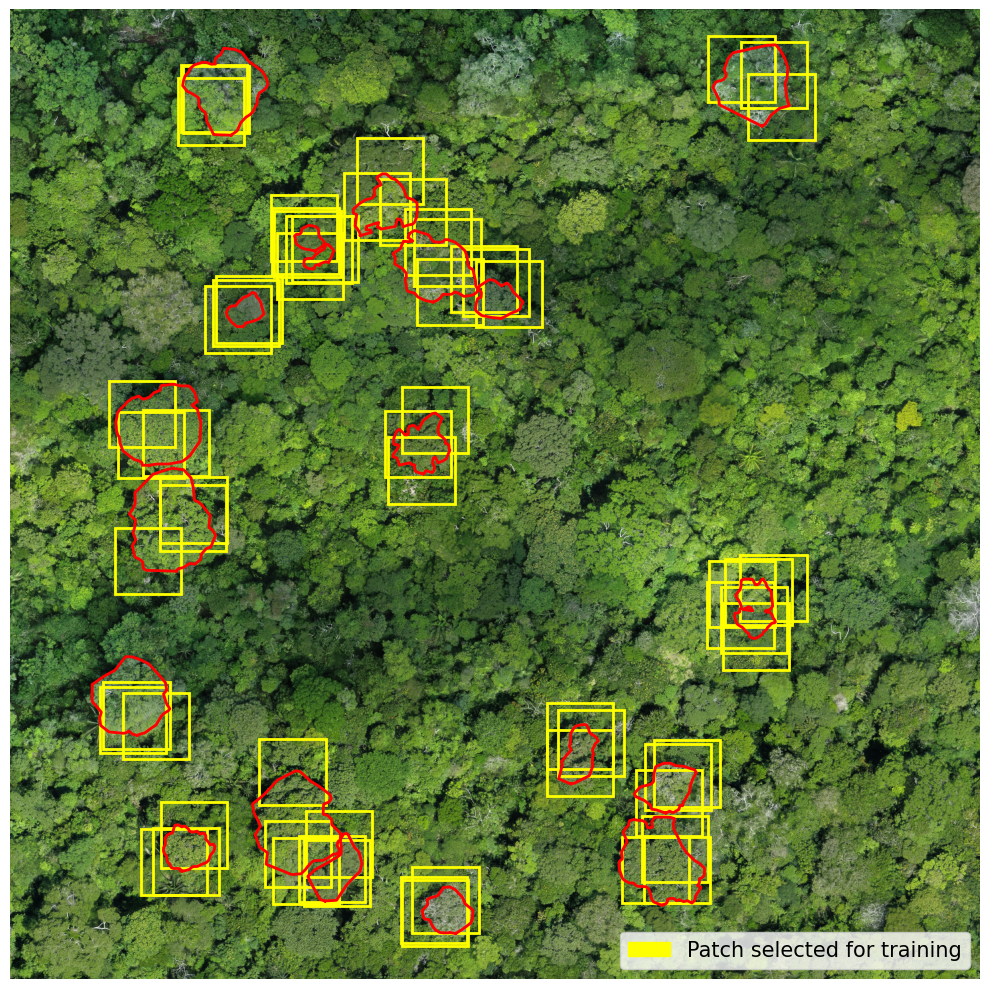

In [32]:
plt.figure(figsize = (10, 10))

plt.imshow(quadrante_raw)

width = 512
height = 512

for contour in find_contours(quadrante_img > 0):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color = "red")


for coord in all_coords:

    rand_x_add = int(np.random.uniform(-55, 55))
    rand_y_add = int(np.random.uniform(-55, 55))
    
    coord_x = coord[1] - width / 2 + rand_x_add
    coord_y = coord[0] - height / 2 + rand_y_add

    box = patches.Rectangle((coord_x, coord_y), width, height, linewidth=2, edgecolor='yellow', 
                            facecolor='none')
    # Get the current axes and add the box to the plot
    plt.gca().add_patch(box)


plt.grid(False)
plt.axis("off")

# Add a yellow line as a "patch" for demonstration
yellow_patch = patches.Patch(color='yellow', label='Patch selected for training')


# Add the yellow line to the plot
plt.legend(handles=[yellow_patch], loc='lower right', fontsize = 15)  # Add legend with yellow line

plt.tight_layout()

# plt.savefig(
#     join("../paper_figures", "quadrado_componentes.jpg"), 
#     transparent = False, 
#     dpi = 100, 
#     bbox_inches = "tight"
# )

plt.show()